In [2]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import datetime as dt
import gc
import glob

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

%matplotlib inline
start_time = dt.datetime.now()

In [3]:
# set some parameters
# I recommend set num_filter to be about 10 to 20% of the original # variables
num_filter = 600

# I recommend set num_wrapper to be about 50, then look for a saturation of the model performance as variables are added
# Then you can run it again with num_wrapper just a bit above this saturation point, not more than about twice this saturation number
num_wrapper = 25

balance = 0
detect_rate = .03

# These are fixed
index_name = 'Recnum'
y_name = 'Fraud'
good_label = 0
bad_label = 1

In [1]:
raw_data = pd.read_csv('card transactions.csv', dtype = object)
raw_data = raw_data.iloc[:, :-8].copy()
raw_data['Date'] = pd.to_datetime(raw_data['Date'])
raw_data

In [4]:
index_last_two_months = raw_data.query("Date < '2010-11-01'")["Recnum"].astype(int).max() # inclusive
index_first_2_weeks = raw_data.query("Date >= '2010-01-15'")["Recnum"].astype(int).min() # inclusive

print(index_first_2_weeks)
print(index_last_two_months)

3345
84299


In [5]:
deduped_files_2_ = glob.glob("output_dedup/2_*.csv") # from deduping variables
deduped_files_2_

['output_dedup\\2_0_dow_risk_dedup.csv',
 'output_dedup\\2_1_benford_law_dedup.csv',
 'output_dedup\\2_2_1_velocity_counts_and_days_since_dedup.csv',
 'output_dedup\\2_2_2_relative_velocity_dedup.csv',
 'output_dedup\\2_3_counts_entities_01_Cardnum_dedup.csv',
 'output_dedup\\2_3_counts_entities_02_Merchnum_dedup.csv',
 'output_dedup\\2_3_counts_entities_03_Merch_description_dedup.csv',
 'output_dedup\\2_3_counts_entities_04_Merch_num_des_dedup.csv',
 'output_dedup\\2_3_counts_entities_05_Merch_num_state_dedup.csv',
 'output_dedup\\2_3_counts_entities_06_Merch_num_zip_dedup.csv',
 'output_dedup\\2_3_counts_entities_07_Merch_des_state_dedup.csv',
 'output_dedup\\2_3_counts_entities_08_Merch_des_zip_dedup.csv',
 'output_dedup\\2_3_counts_entities_09_Merch_state_zip_dedup.csv',
 'output_dedup\\2_3_counts_entities_10_Merch_num_des_state_dedup.csv',
 'output_dedup\\2_3_counts_entities_11_Merch_num_des_zip_dedup.csv',
 'output_dedup\\2_3_counts_entities_12_Merch_num_state_zip_dedup.csv',
 'o

In [6]:
# Remove benford_law
deduped_files_2_.remove('output_dedup\\2_1_benford_law_dedup.csv')
deduped_files_2_

['output_dedup\\2_0_dow_risk_dedup.csv',
 'output_dedup\\2_2_1_velocity_counts_and_days_since_dedup.csv',
 'output_dedup\\2_2_2_relative_velocity_dedup.csv',
 'output_dedup\\2_3_counts_entities_01_Cardnum_dedup.csv',
 'output_dedup\\2_3_counts_entities_02_Merchnum_dedup.csv',
 'output_dedup\\2_3_counts_entities_03_Merch_description_dedup.csv',
 'output_dedup\\2_3_counts_entities_04_Merch_num_des_dedup.csv',
 'output_dedup\\2_3_counts_entities_05_Merch_num_state_dedup.csv',
 'output_dedup\\2_3_counts_entities_06_Merch_num_zip_dedup.csv',
 'output_dedup\\2_3_counts_entities_07_Merch_des_state_dedup.csv',
 'output_dedup\\2_3_counts_entities_08_Merch_des_zip_dedup.csv',
 'output_dedup\\2_3_counts_entities_09_Merch_state_zip_dedup.csv',
 'output_dedup\\2_3_counts_entities_10_Merch_num_des_state_dedup.csv',
 'output_dedup\\2_3_counts_entities_11_Merch_num_des_zip_dedup.csv',
 'output_dedup\\2_3_counts_entities_12_Merch_num_state_zip_dedup.csv',
 'output_dedup\\2_3_counts_entities_13_Merch_de

# Run a filter on all the files

In [7]:
%%time
filter_score_df_list = []

# KK: I add this in addition to Prof. His original code will not work in the exact same way for multiple files
filter_score_all = pd.DataFrame(np.zeros((0,3)))
filter_score_all.columns = ['filename','variable','filter score']

for file_path in deduped_files_2_:
    
    # These are for selecting file
    df = pd.read_csv(file_path)
    file_name = file_path.replace(".csv", "").split('\\')[1] # KK: I separated file_path and file_name
    print("********** working on", file_name, "size is", df.shape)
    
    
    # These are for spliting train-test set and also excluded the first two weeks
    df = df.set_index(index_name)
    df = df[df.index <= index_last_two_months] # remove the last two months as the out-of-time data (OOT)
    df = df[df.index >= index_first_2_weeks] # remove the first 2 weeks of records since their variables aren't well formed
    
    
    # Spliting into 2 dataset: goods and bads
    df['RANDOM'] = np.random.ranf(len(df)) # add a random number variable to make sure it doesn't come up as important
    goods = df[df[y_name] == good_label]
    bads = df[df[y_name] == bad_label]

    del df # don't need this file anymore
    
    num_goods = len(goods)
    num_bads = len(bads)
    num_vars = len(bads.columns)-2
    
    
    # Calculating filter score
    filter_score = pd.DataFrame(np.zeros((num_vars+1,3)))
    filter_score.columns = ['filename','variable','filter score'] # KK: Note that I add filename here
    filter_score.loc[:,'filename'] = file_name
    
    j = 0
    for column in bads:
        filter_score.loc[j,'variable'] = column
        filter_score.loc[j,'filter score'] = sps.ks_2samp(goods[column],bads[column])[0]
        j = j+1
        if j%20 == 0:
            print(j, end=" ")
    print(j)
    del goods # delete these before starting the next file, if any
    del bads
    filter_score_all = pd.concat([filter_score_all, filter_score], axis=0) # KK: I append my filter_all DataFrame here
    gc.collect()

filter_score_all.sort_values(by=['filter score'], ascending=False, inplace=True)
filter_score_all = filter_score_all.drop_duplicates(subset="variable")
filter_score_all.to_csv('output_selected/1_filter_score_all.csv', index=False)
print(filter_score_all[['variable', 'filter score']].head(20))

********** working on 2_0_dow_risk_dedup size is (96397, 3)
3
********** working on 2_2_1_velocity_counts_and_days_since_dedup size is (96397, 2174)
20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700 720 740 760 780 800 820 840 860 880 900 920 940 960 980 1000 1020 1040 1060 1080 1100 1120 1140 1160 1180 1200 1220 1240 1260 1280 1300 1320 1340 1360 1380 1400 1420 1440 1460 1480 1500 1520 1540 1560 1580 1600 1620 1640 1660 1680 1700 1720 1740 1760 1780 1800 1820 1840 1860 1880 1900 1920 1940 1960 1980 2000 2020 2040 2060 2080 2100 2120 2140 2160 2174
********** working on 2_2_2_relative_velocity_dedup size is (96397, 682)
20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 682
********** working on 2_3_counts_entities_01_Cardnum_dedup size is (96397, 97)
20 40 60 80 97
********** working on 2_3_counts_entities_02_Merchnum_de

### filter_score_all saved here

In [8]:
# KK: Keeping variables
filter_score_all = pd.read_csv('output_selected/1_filter_score_all.csv')
filter_score_keep = filter_score_all[1:].head(num_filter)
vars_keep = list(filter_score_keep["variable"])

In [9]:
i = 0
for file_path in deduped_files_2_:
    
    # KK: These are the same as previous
    df = pd.read_csv(file_path)
    file_name = file_path.replace(".csv", "").split('\\')[1]
    print("********** working on", file_name, "size is", df.shape)

    df = df.set_index(index_name)
    # KK: I don't want this two. I will do it later.
#     df = df[df.index <= index_last_two_months]
#     df = df[df.index >= index_first_2_weeks]
    
    
    # KK: These are added
    if(i == 0): # if first time through need to initialize some stuff
        Y = pd.DataFrame(df[y_name], index=df.index)
        df_keep = df.filter(vars_keep, axis=1) # KK: I changed this to df_keep
            
    if(i > 0): # if more than one variable file we use this loop
        data_new_top = df.filter(vars_keep, axis=1)
        df_keep = pd.concat([df_keep, data_new_top], axis=1) # KK: I changed this to df_keep
        del data_new_top

    del df
    i += 1
    gc.collect()

********** working on 2_0_dow_risk_dedup size is (96397, 3)
********** working on 2_2_1_velocity_counts_and_days_since_dedup size is (96397, 2174)
********** working on 2_2_2_relative_velocity_dedup size is (96397, 682)
********** working on 2_3_counts_entities_01_Cardnum_dedup size is (96397, 97)
********** working on 2_3_counts_entities_02_Merchnum_dedup size is (96397, 100)
********** working on 2_3_counts_entities_03_Merch_description_dedup size is (96397, 97)
********** working on 2_3_counts_entities_04_Merch_num_des_dedup size is (96397, 45)
********** working on 2_3_counts_entities_05_Merch_num_state_dedup size is (96397, 51)
********** working on 2_3_counts_entities_06_Merch_num_zip_dedup size is (96397, 46)
********** working on 2_3_counts_entities_07_Merch_des_state_dedup size is (96397, 51)
********** working on 2_3_counts_entities_08_Merch_des_zip_dedup size is (96397, 43)
********** working on 2_3_counts_entities_09_Merch_state_zip_dedup size is (96397, 51)
********** work

In [10]:
filter_score_all.sort_values(by=['filter score'], ascending=False, inplace=True)
filter_score_all.reset_index(drop=True, inplace=True)

In [11]:
df_keep = df_keep[vars_keep].copy() # KK: To sort columns
df_keep.head()

,card_Merch_state_zip_total_7,card_Merch_zip_total_7,card_Merch_num_state_total_7,card_Merchnum_total_7,card_Merch_num_state_zip_total_7,card_Merch_num_zip_total_7,card_Merch_num_state_total_14,card_Merch_state_zip_total_3,card_Merch_num_state_total_3,card_Merch_zip_total_3,...,Cardnum_count_7,Merch_all_info_variability_min_1,Merch_num_des_zip_variability_min_1,card_Merch_num_des_zip_variability_min_7,Cardnum_variability_std_14,Cardnum_std_14,Merch_num_state_zip_variability_avg_30,Merch_num_zip_variability_avg_30,card_Merch_num_des_variability_min_14,card_Merch_num_des_state_variability_min_14
Recnum,,,,,,,,,,,,,,,,,,,,,
47340,51000.00,51000.00,51000.00,51000.00,51000.00,51000.00,51000.00,51000.00,51000.00,51000.00,...,2,-44800.00,-44800.00,-44800.00,31678.383797,31678.383797,-47416.016304,-47408.12691,-44800.00,-44800.00
59517,45477.28,45477.28,45477.28,45477.28,45477.28,45477.28,45477.28,45477.28,45477.28,45477.28,...,8,-29409.88,-29409.88,-29409.88,10228.294339,10228.294339,-25448.897000,-25448.89700,-29409.88,-29409.88
80887,28392.84,28392.84,28392.84,28392.84,28392.84,28392.84,28392.84,28392.84,28392.84,28392.84,...,3,0.00,0.00,0.00,14194.231673,14194.231673,0.000000,0.00000,0.00,0.00
89674,27218.00,27218.00,27218.00,27218.00,27218.00,27218.00,27218.00,27218.00,27218.00,27218.00,...,5,0.00,0.00,0.00,12019.548043,12019.548043,0.000000,0.00000,0.00,0.00
1104,26910.00,26910.00,26910.00,26910.00,26910.00,26910.00,26910.00,26910.00,26910.00,26910.00,...,4,0.00,0.00,0.00,12527.076066,12527.076066,0.000000,0.00000,0.00,0.00


In [12]:
# KK: To save the progress
df_keep.to_csv('output_selected/1_df_keep.csv', index=True)
Y.to_csv('output_selected/1_Y.csv', index=True)

### df_keep saved here

In [268]:
df_keep = pd.read_csv('output_selected/1_df_keep.csv', index_col = index_name).sort_index()
df_keep = df_keep[df_keep.index <= index_last_two_months]
df_keep = df_keep[df_keep.index >= index_first_2_weeks]

In [269]:
Y = pd.read_csv('output_selected/1_Y.csv', index_col = index_name).sort_index()
Y = Y[Y.index <= index_last_two_months]
Y = Y[Y.index >= index_first_2_weeks]

In [270]:
Y = Y.values
Y_save = Y.copy()

In [271]:
# Y = np.array(Y)
X = df_keep.dropna(axis=1)
print(Y)

[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


In [273]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 3:30:27.531576


In [274]:
print(X.shape,Y.shape)

(80632, 596) (80632, 1)


In [275]:
print(type(X),type(Y))

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>


# Run a wrapper on the remaining top variables

In [21]:
# I'd like to define a scoring for the wrapper that's KS, but I haven't gotten around to this yet.
# def KSscore(classifier, x,y)
#     goods = ## Run a wrapper on the remaining top variables

In [228]:
def fdr(classifier, x, y, cutoff=detect_rate):
    # Calculates FDR score for the given classifier on dataset x and y with cutoff value
    # get the probability list from the given classifier
    return fdr_prob(y, classifier.predict_proba(x), cutoff)

def fdr_prob(y, y_prob, cutoff=detect_rate):
    if len(y_prob.shape) != 1:    # sometimes the proba list can contain many columns, one for each category
        y_prob = y_prob[:, -1:]   # only the last one (fraud_label==1) is used here.
    num_fraud = len(y[y == 1])    # count the total nunber of frauds
    
    # sort the proba list from high to low while retain the true (not predicted) fraud label
    sorted_prob = np.asarray(sorted(zip(y_prob, y), key=lambda x: x[0], reverse=True))
    cutoff_bin = sorted_prob[0:int(len(y) * cutoff), 1:]  # 3% cutoff
    
    # return the FDR score (#fraud_in_cutoff / #total_fraud)
    return len(cutoff_bin[cutoff_bin == 1]) / num_fraud ## Run a wrapper on the remaining top variables

## LGBMClassifier(n_estimators=20, num_leaves=3)

In [238]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
# If you're doing forward selection it's enough to stop at num_wrapper variables. 
# If you're doing backward selection you need to go through all the variables to get a sorted list of num_wrapper variables.

# I can't figure out how to get rid of this annoying warning! I don't know what I'm doing wrong...

def wrapper_execution(algorithm = LGBMClassifier(n_estimators=20, num_leaves=3),
                      title = 'Stepwise Selection',
                      filename = 'performance_nvars.png',
                      forward_flag=True,
                      num_wrapper=num_wrapper, cv=3):
    nfeatures = len(X.columns)
    # clf = RandomForestClassifier(n_estimators=5) # simple, fast nonlinear model for the wrapper
    # clf = LGBMClassifier(n_estimators=20, num_leaves=3) # Gradient Boosting: simple, fast nonlinear model for the wrapper
    
    clf = algorithm
    sfs = SFS(clf,
              k_features= num_wrapper,
              forward=forward_flag,
              verbose=0,
              scoring=fdr,
              cv=cv,
              n_jobs=-1) # use for forward selection
    # sfs = SFS(clf,k_features=1,forward=False,verbose=0,scoring=fdr,cv=3,n_jobs=-1) # use for backward selection
    sfs.fit(X, Y.ravel())

    fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev', figsize=(15, 6))

    plt.xticks(np.arange(0, len(X.columns), step=5))
    plt.yticks(np.arange(0,1,step=.1))
    plt.ylim([0., 1])
    plt.xlim(0,num_wrapper)
    plt.title(title)
    plt.grid()
    plt.savefig(filename)
    plt.show()
    
    return sfs, fig1

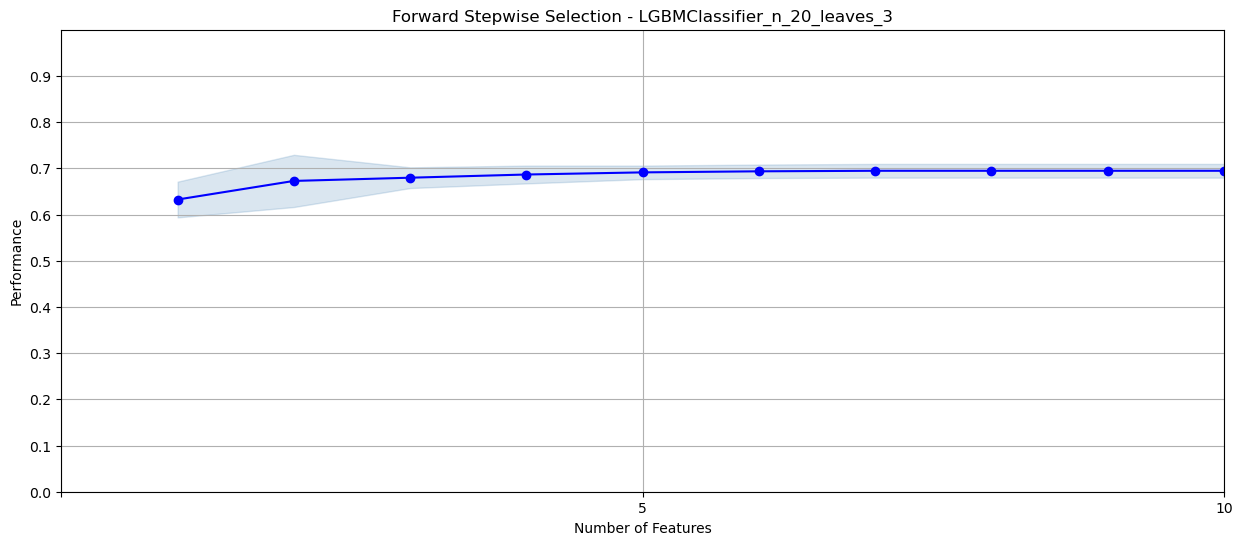

time to here: 2:22:34.524625
Wall time: 5min 12s


In [240]:
%%time
sfs_forward_LGBM_20_3 = wrapper_execution(algorithm = LGBMClassifier(n_estimators=20, num_leaves=3),
                                          title = 'Forward Stepwise Selection - LGBMClassifier_n_20_leaves_3',
                                          filename = 'wrapper_LGBMClassifier_n_20_leaves_3_forward_10.png',
                                          num_wrapper=10,
                                          forward_flag=True)

print('time to here:', dt.datetime.now() - start_time)

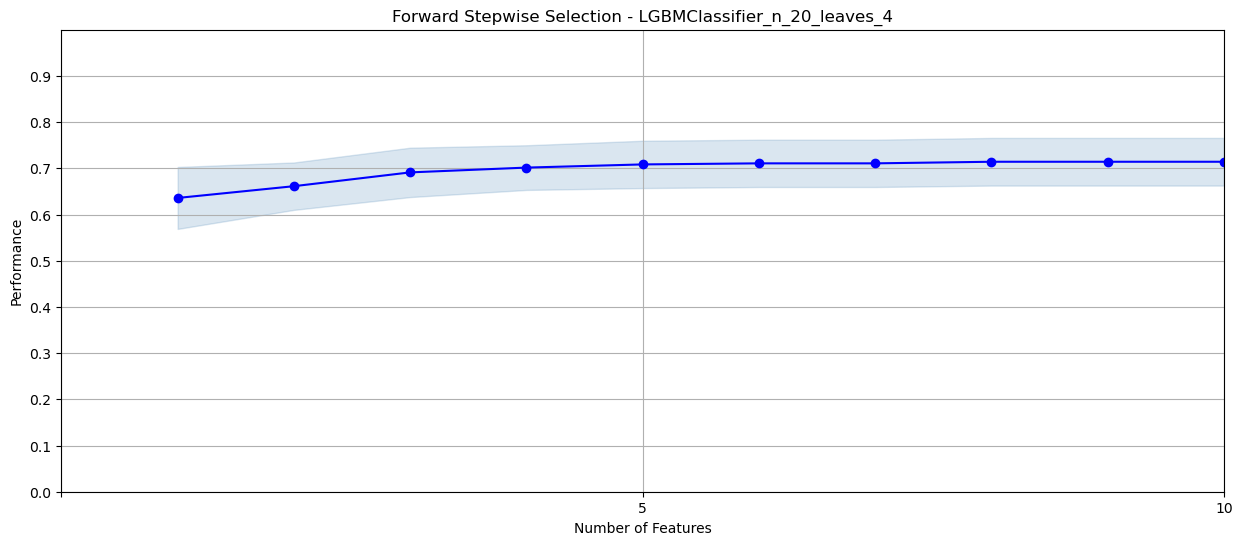

time to here: 2:33:32.514296
Wall time: 5min 18s


In [242]:
%%time
sfs_forward_LGBM_20_4 = wrapper_execution(algorithm = LGBMClassifier(n_estimators=20, num_leaves=4),
                                          title = 'Forward Stepwise Selection - LGBMClassifier_n_20_leaves_4',
                                          filename = 'wrapper_LGBMClassifier_n_20_leaves_4_forward_10.png',
                                          num_wrapper=10,
                                          forward_flag=True)

print('time to here:', dt.datetime.now() - start_time)

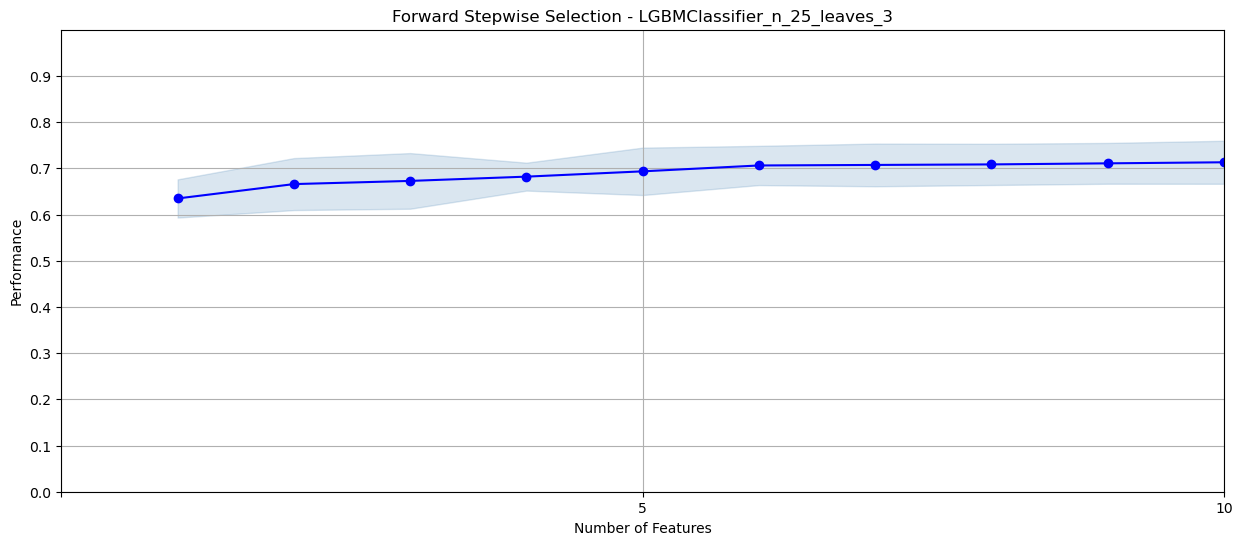

time to here: 2:39:12.505646
Wall time: 5min 39s


In [243]:
%%time
sfs_forward_LGBM_25_3 = wrapper_execution(algorithm = LGBMClassifier(n_estimators=25, num_leaves=3),
                                          title = 'Forward Stepwise Selection - LGBMClassifier_n_25_leaves_3',
                                          filename = 'wrapper_LGBMClassifier_n_25_leaves_3_forward_10.png',
                                          num_wrapper=10,
                                          forward_flag=True)

print('time to here:', dt.datetime.now() - start_time)

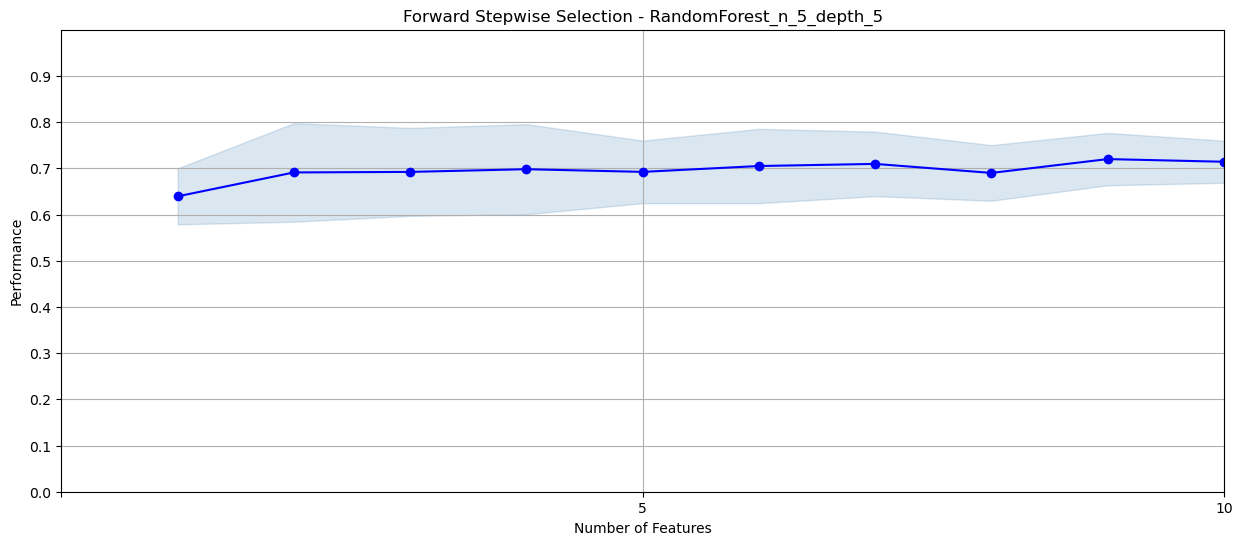

time to here: 2:46:40.269424
Wall time: 7min 27s


In [244]:
%%time
sfs_forward_random_5_5 = wrapper_execution(algorithm = RandomForestClassifier(n_estimators=5, max_depth=5),
                                           title = 'Forward Stepwise Selection - RandomForest_n_5_depth_5',
                                           filename = 'wrapper_RandomForest_n_5_depth_5_forward.png',
                                           num_wrapper=10,
                                           forward_flag=True)

print('time to here:', dt.datetime.now() - start_time)

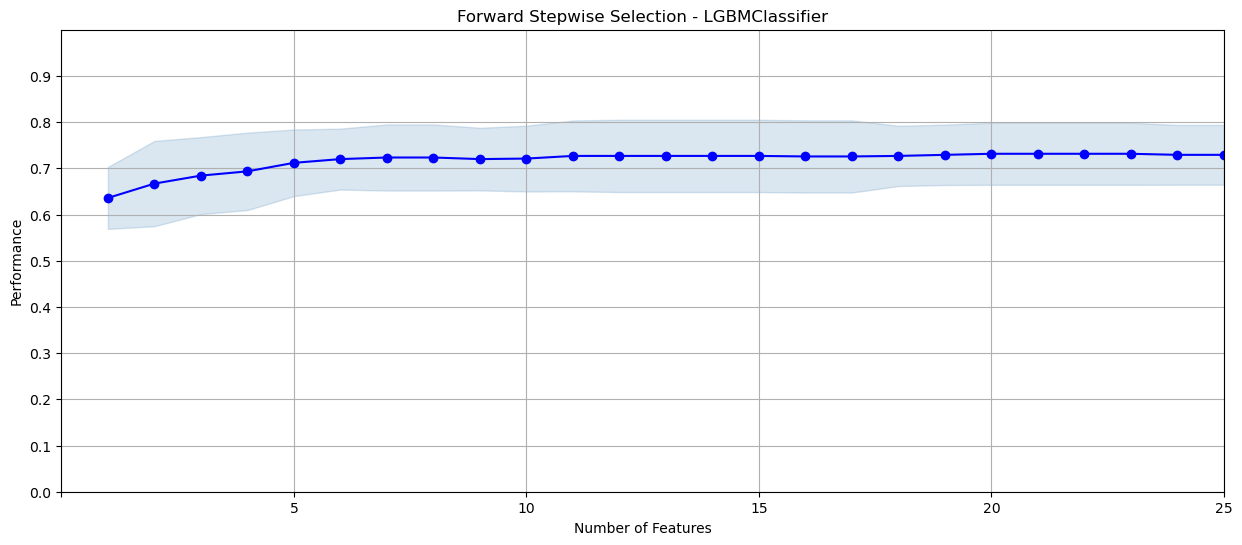

time to here: 3:15:45.472613
Wall time: 19min 23s


In [245]:
%%time
sfs_forward_LGBM = wrapper_execution(algorithm = LGBMClassifier(n_estimators=30, num_leaves=4),
                                     title = 'Forward Stepwise Selection - LGBMClassifier',
                                     filename = 'wrapper_LGBMClassifier_n_30_leaves_4_forward.png',
                                     forward_flag=True)

print('time to here:', dt.datetime.now() - start_time)

In [276]:
vars_FS = pd.DataFrame.from_dict(sfs_forward_LGBM[0].get_metric_dict()).T

In [277]:
ordered_vars_FS = vars_FS.copy()
for i in range(len(ordered_vars_FS)):
    ordered_vars_FS.loc[i+1,'add variables in this order'] = int(i+1)
    if i+1 == 1:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(ordered_vars_FS.loc[i+1,'feature_names'])[0])
    else:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(set(ordered_vars_FS.loc[i+1,'feature_names']) - set(ordered_vars_FS.loc[i,'feature_names'])))[0]
# You might also need this following line. It converts a list to a string
        #         ordered_vars_FS.loc[i+1,'variable name'] = ordered_vars_FS.loc[i+1,'variable name'][0]

In [278]:
ordered_vars_FS

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,add variables in this order,variable name
1,"(6,)","[0.7137931034482758, 0.5501730103806228, 0.643...",0.635855,"(card_Merch_num_state_total_14,)",0.150821,0.067022,0.047391,1.0,card_Merch_num_state_total_14
2,"(6, 95)","[0.7758620689655172, 0.5501730103806228, 0.674...",0.666925,"(card_Merch_num_state_total_14, card_Merchnum_...",0.207712,0.092303,0.065268,2.0,card_Merchnum_max_30
3,"(6, 95, 117)","[0.7689655172413793, 0.5709342560553633, 0.712...",0.684234,"(card_Merch_num_state_total_14, card_Merchnum_...",0.187523,0.083332,0.058924,3.0,card_Merch_des_zip_total_1
4,"(6, 95, 117, 280)","[0.7827586206896552, 0.5813148788927336, 0.716...",0.693445,"(card_Merch_num_state_total_14, card_Merchnum_...",0.188593,0.083807,0.05926,4.0,Merch_description_total_0
5,"(6, 18, 95, 117, 280)","[0.7896551724137931, 0.615916955017301, 0.7301...",0.711892,"(card_Merch_num_state_total_14, card_Merch_sta...",0.162221,0.072088,0.050974,5.0,card_Merch_state_zip_total_14
6,"(6, 18, 65, 95, 117, 280)","[0.7931034482758621, 0.6332179930795848, 0.733...",0.719962,"(card_Merch_num_state_total_14, card_Merch_sta...",0.148472,0.065978,0.046653,6.0,card_Merch_des_state_max_30
7,"(6, 18, 65, 80, 95, 117, 280)","[0.803448275862069, 0.629757785467128, 0.73702...",0.72341,"(card_Merch_num_state_total_14, card_Merch_sta...",0.161032,0.071559,0.0506,7.0,card_Merch_des_zip_max_30
8,"(6, 18, 65, 80, 81, 95, 117, 280)","[0.803448275862069, 0.629757785467128, 0.73702...",0.72341,"(card_Merch_num_state_total_14, card_Merch_sta...",0.161032,0.071559,0.0506,8.0,card_Merch_des_state_zip_max_30
9,"(6, 18, 65, 80, 81, 95, 117, 175, 280)","[0.7931034482758621, 0.629757785467128, 0.7370...",0.719962,"(card_Merch_num_state_total_14, card_Merch_sta...",0.152501,0.067768,0.047919,9.0,card_Merch_num_des_zip_total_0
10,"(6, 18, 65, 74, 80, 81, 95, 117, 175, 280)","[0.803448275862069, 0.629757785467128, 0.73010...",0.721103,"(card_Merch_num_state_total_14, card_Merch_sta...",0.16021,0.071194,0.050342,10.0,card_Merch_des_state_zip_total_30


In [279]:
ordered_vars_FS.to_csv('output_selected/2_wrapper_selection_info.csv', index=False)

In [281]:
vars_keep = ordered_vars_FS['variable name']
vars_keep.to_csv('output_selected/2_final_vars_list.csv',index=False)

### wrapper saved here

In [282]:
ordered_vars_FS = pd.read_csv('output_selected/2_wrapper_selection_info.csv')
vars_keep = pd.read_csv('output_selected/2_final_vars_list.csv')["variable name"]

vars_keep_list = vars_keep.tolist()
vars_keep

0          card_Merch_num_state_total_14
1                   card_Merchnum_max_30
2             card_Merch_des_zip_total_1
3              Merch_description_total_0
4          card_Merch_state_zip_total_14
5            card_Merch_des_state_max_30
6              card_Merch_des_zip_max_30
7        card_Merch_des_state_zip_max_30
8         card_Merch_num_des_zip_total_0
9      card_Merch_des_state_zip_total_30
10      card_Merch_num_state_zip_total_0
11     card_Merch_num_state_zip_total_30
12           card_Merch_des_zip_total_30
13            card_Merch_num_zip_total_0
14            card_Merch_des_zip_total_0
15          card_Merch_state_zip_total_0
16         card_Merch_num_state_total_30
17    Merch_state_zip_variability_avg_14
18            card_Merch_num_des_total_0
19         card_Merch_des_state_total_30
20          card_Merch_des_state_total_0
21        card_Merch_description_total_0
22                card_Merch_zip_total_0
23       card_Merch_num_des_zip_total_14
24       card_Me

In [283]:
filter_score_all.set_index('variable', drop=True, inplace=True)
filter_score_all = filter_score_all.iloc[1:,1:] # KK: I have filename as well so I need to remove one column

vars_keep_sorted = pd.DataFrame(vars_keep_list)
vars_keep_sorted.columns=['variable']
vars_keep_sorted.set_index('variable',drop=True,inplace=True)

vars_keep_sorted = pd.concat([vars_keep_sorted, filter_score_all], axis=1, join='inner')
vars_keep_sorted

vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted['index'] = vars_keep_sorted['index'] + 1
vars_keep_sorted.rename(columns={'index':'wrapper order'}, inplace=True)
vars_keep_sorted.to_csv('output_selected/2_vars_keep_sorted.csv', index=False)
vars_keep_sorted

,wrapper order,variable,filter score
0,1,card_Merch_num_state_total_14,0.676009
1,2,card_Merchnum_max_30,0.648741
2,3,card_Merch_des_zip_total_1,0.634249
3,4,Merch_description_total_0,0.581051
4,5,card_Merch_state_zip_total_14,0.670752
5,6,card_Merch_des_state_max_30,0.654715
6,7,card_Merch_des_zip_max_30,0.651810
7,8,card_Merch_des_state_zip_max_30,0.651810
8,9,card_Merch_num_des_zip_total_0,0.602714
9,10,card_Merch_des_state_zip_total_30,0.652168


In [284]:
vars_keep_list.append(index_name)
vars_keep_list.append(y_name)
vars_keep_list

['card_Merch_num_state_total_14',
 'card_Merchnum_max_30',
 'card_Merch_des_zip_total_1',
 'Merch_description_total_0',
 'card_Merch_state_zip_total_14',
 'card_Merch_des_state_max_30',
 'card_Merch_des_zip_max_30',
 'card_Merch_des_state_zip_max_30',
 'card_Merch_num_des_zip_total_0',
 'card_Merch_des_state_zip_total_30',
 'card_Merch_num_state_zip_total_0',
 'card_Merch_num_state_zip_total_30',
 'card_Merch_des_zip_total_30',
 'card_Merch_num_zip_total_0',
 'card_Merch_des_zip_total_0',
 'card_Merch_state_zip_total_0',
 'card_Merch_num_state_total_30',
 'Merch_state_zip_variability_avg_14',
 'card_Merch_num_des_total_0',
 'card_Merch_des_state_total_30',
 'card_Merch_des_state_total_0',
 'card_Merch_description_total_0',
 'card_Merch_zip_total_0',
 'card_Merch_num_des_zip_total_14',
 'card_Merch_description_total_30',
 'Recnum',
 'Fraud']

### var_final saved here

In [285]:
%%time
df_keep = pd.read_csv('output_selected/1_df_keep.csv')
Y = pd.read_csv('output_selected/1_Y.csv')

df_keep_with_Y = pd.concat([Y, df_keep.iloc[:,1:]], axis = 1)
del df_keep, Y

df_keep_with_Y.shape

Wall time: 6.58 s


(96397, 602)

In [286]:
df_keep_with_Y = df_keep_with_Y.filter(vars_keep_list, axis=1)
print(df_keep_with_Y.shape)

(96397, 27)


In [287]:
df_keep_with_Y.to_csv('output_selected/2_df_final_with_Y.csv',index=False)

In [288]:
print("duration: ", dt.datetime.now() - start_time)

duration:  3:31:06.073977
